# Problem Set 2
## UCSF NS248, Winter 2023

### Solutions by Max Collard

---

In [104]:
import itertools

import numpy as np
import scipy.integrate as sint
import scipy.stats as sstats
import matplotlib.pyplot as plt

from tqdm import tqdm

---

## Problem 1

> Write a function that generates a gaussian distribution given three inputs:
> 1) the x coordinates for the points to be returned,
> 2) the mean and
> 3) the standard deviation.
>
> e.g. `f = gaussian(xvals, mean, stdev)`

In [25]:
def gaussian_pdf( mean = 0., stdev = 1. ):
    """Returns a function that evaluates a Gaussian pdf (default: standard normal)"""
    return lambda xs: ( (1./(stdev * np.sqrt( 2. * np.pi )))
                        * np.exp( -(1./2) * np.power( (xs - mean) / stdev, 2 ) ) )

> Use this function to generate a gaussian from -6 to 6 with 10000 points, a mean of 0 and a standard deviation of 1. Plot the CDF of this distribution and use the CDF to estimate the probability that a random draw from this gaussian distribution would be
> 
> a. 1 standard deviation or more from the mean.
>
> b. 2 standard deviations or more from the mean.
>
> c. 3 standard deviations or more from the mean.

In [26]:
xs = np.linspace( -6, 6, 10000 )
pdf = gaussian_pdf()
pdf_values = pdf( xs )

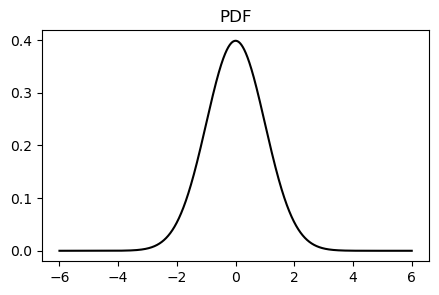

In [27]:
plt.figure( figsize = (5, 3) )
plt.plot( xs, pdf_values, 'k-' )
plt.title( 'PDF' )
plt.show()

In [28]:
def pdf_to_cdf( pdf, xs ):
    """Given a function that evaluates a pdf, determine the cdf using trapezoidal integration"""
    # We have to append a 0 because the integrator returns a value for each dx, not each x
    return np.r_[0, sint.cumulative_trapezoid( pdf( xs ), xs )]

In [29]:
cdf_values = pdf_to_cdf( pdf, xs )

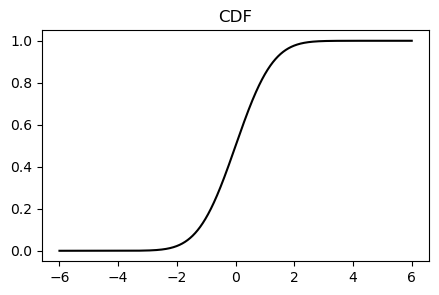

In [30]:
plt.figure( figsize = (5, 3) )
plt.plot( xs, cdf_values, 'k-' )
plt.title( 'CDF' )
plt.show()

In [31]:
def function_interpolator_lattice( xs, ys ):
    return lambda x_new: np.interp( x_new, xs, ys )

In [32]:
cdf = function_interpolator_lattice( xs, cdf_values )

The probability of being $v$ standard deviations or more from the mean is the sum of two parts:

* The left side: $CDF(-a)$
    * This is defined to be $\operatorname{Pr}(X \leq v)$
* The right side: $1 - CDF(v)$
    * This is because $\operatorname{Pr}(X \geq v) = \operatorname{Pr}((X \leq v)^c) = 1 - \operatorname{Pr}(X \leq v)$

In [40]:
questions = {
    '1a': 1,
    '1b': 2,
    '1c': 3
}

answers = { q: cdf( -v) + (1 - cdf( v ))
            for q, v in questions.items() }

In [41]:
answers

{'1a': 0.31731063129265,
 '1b': 0.04550028981720722,
 '1c': 0.0026998028434342463}

---

## Problem 2

> Generate 1000 random draws from the gaussian distribution you generated in question 2 using its CDF and uniform random numbers between 0 and 1. Verify the answers to 2a, b and c. Suggestion: Write a general purpose random draw function that takes as its input a CDF and the number of points to draw.

In [42]:
def function_inverse_interpolator_lattice( xs, ys ):
    return lambda y_new: np.interp( y_new, ys, xs )

In [59]:
def random_generator( cdf_xs, cdf_values ):
    f = function_inverse_interpolator_lattice( cdf_xs, cdf_values )
    def gen( size = (1,) ):
        u = np.random.uniform( size = size )
        return f( u )
    return gen

In [60]:
xs = np.linspace( -6, 6, 10000 )

pdf = gaussian_pdf()
pdf_values = pdf( xs )
cdf_values = pdf_to_cdf( pdf, xs )
generator = random_generator( xs, cdf_values )

values = generator( size = (1000,) )

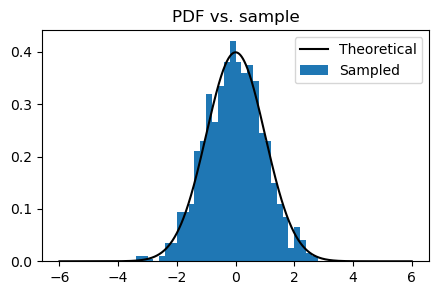

In [61]:
plt.figure( figsize = (5, 3) )

plt.plot( xs, pdf_values, 'k-',
          label = 'Theoretical' )
plt.hist( values,
          bins = np.arange( -6, 6, 0.2 ),
          density = True,
          label = 'Sampled' )

plt.legend()
plt.title( 'PDF vs. sample' )

plt.show()

---

## Problem 3

> Suppose you are performing a behavioral experiment where you measure the amount of time it takes for two groups of mice (wild-type and knockout) to find the hidden platform in a Morris Water Maze. Assume that you have 10 mice in each group and that after learning the escape latency is distributed as a gaussian.

> a. If the actual standard deviations are 10 seconds for both groups, the actual mean time for group 1 is 20 seconds and the actual mean time for group 2 is 30 seconds, what is the probability that you will detect the difference between the groups? The easiest way to do this is to simulate the data and see how often the differences come out significant.

In [81]:
def simulate( group_ns, group_means, group_stds,
              n_std = 10,
              n_points = 10000 ):
    """TODO"""
    
    if group_means.keys() != group_stds.keys():
        raise ValueError( 'Malformed parameters.' )
    
    group_generators = dict()
    for group in group_means.keys():
        xs = np.linspace( group_means[group] - (n_std * group_stds[group]),
                          group_means[group] + (n_std * group_stds[group]), n_points )
        
        pdf = gaussian_pdf( mean = group_means[group],
                            stdev = group_stds[group] )
        pdf_values = pdf( xs )
        cdf_values = pdf_to_cdf( pdf, xs )
        group_generators[group] = random_generator( xs, cdf_values )
    
    data = dict()
    for group, generator in group_generators.items():
        data[group] = generator( size = (group_ns[group],) )
    
    return data

In [98]:
def evaluate( data,
              test = sstats.ttest_ind ):
    """TODO"""
    
    # This ensures there is a unique (sorted) order to the groups
    groups = list( sorted( data.keys() ) )
    
    ret = dict()
    for group_a, group_b in itertools.combinations( groups, 2 ):
        ret[(group_a, group_b)] = test( data[group_a], data[group_b] ).pvalue
    return ret

### Parameters

In [148]:
group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 20,
    'B': 30,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

### Run: $t$-test

In [149]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 701.88it/s]


The power is the probability of rejecting the null hypothesis:

In [150]:
power = np.sum( ps_comparison < alpha ) / n_runs
print( f'Power: {power}' )

Power: 0.5602


### Run: Wilcoxon rank-sum

Compare this for the situation with a nonparametric test:

In [151]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ),
                       test = sstats.ranksums )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 626.92it/s]


In [152]:
power = np.sum( ps_comparison < alpha ) / n_runs
print( f'Power: {power}' )

Power: 0.5427


In this particular case, we lose a *little* power, but not much.

> b. Suppose that the two populations are actually identical, and that both have a mean time of 25 seconds and a standard deviation of 10. Simulate the experiment 1000 times (e.g. do random draws to get a set of times for each group) and determine how often a two sample $t$-test returns a significance result at the default significance level. How is that number of incorrect outcomes related to the significance level?

### Parameters

In [153]:
group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 15,
    'B': 15,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 2000
comparison_key = ('A', 'B')

alpha = 0.05

### Usual significance threshold ($\alpha = 0.05$)

In [154]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 684.17it/s]


The empirical type I error is the probability of rejecting the null hypothesis under the null hypothesis:

In [156]:
alpha_empirical = np.sum( ps_comparison < alpha ) / n_runs
print( f'Expected Type I error:  {alpha}' )
print( f'Empirical Type I error: {alpha_empirical}' )

Empirical Type I error: 0.0505


That matches the significance threshold pretty well!

### Varying the significance threshold

In [157]:
alphas_test = np.arange( 0.005, 0.11, 0.005 )

alphas_empirical = np.zeros( alphas_test.shape )
for i_alpha, alpha in tqdm( enumerate( alphas_test ),
                            total = len( alphas_test ) ):
    ps_comparison = []
    for i_run in range( n_runs ):
        run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
        ps_comparison.append( run_ps[comparison_key] )
    ps_comparison = np.array( ps_comparison )
    alphas_empirical[i_alpha] = np.sum( ps_comparison < alpha ) / n_runs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:59<00:00,  2.82s/it]


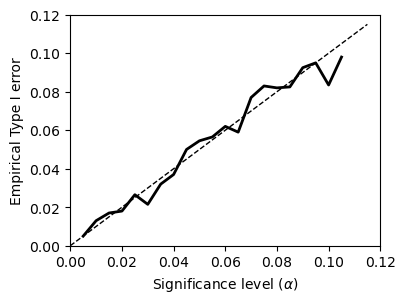

In [158]:
plt.figure( figsize = (4, 3) )

plt.plot( alphas_test, alphas_empirical, 'k-', linewidth = 2 )
plt.plot( [0, 0.115], [0, 0.115], 'k--', linewidth = 1 )

plt.xlabel( 'Significance level ($\\alpha$)' )
plt.ylabel( 'Empirical Type I error' )

plt.xlim( 0, 0.12 )
plt.ylim( 0, 0.12 )

plt.show()

> c. Suppose you were testing four pairs of groups (where each pair is independent and separate from the other pairs) with 10 mice each. What is the probability that one or more of the four tests would result in a significant difference at the $p < 0.05$ level?

### Theoretical

Under the null hypothesis, whether we reject the null hypothesis is a Bernoulli random variable with $p = \alpha$ by definition.

This means that the number of rejections $R$ of $N$ independent hypothesis tests is a binomial random variable, with $n = N$ and $p = \alpha$. So,

$$
\begin{eqnarray*}
    \operatorname{Pr}(R \geq 1) & = & 1 - \operatorname{Pr}(R < 1) \\
        & = & 1 - \operatorname{Pr}(R = 0) \\
        & = & 1 - \binom{N}{0}\,\alpha^0\,(1 - \alpha)^N \\
        & = & 1 - (1 - \alpha)^N
\end{eqnarray*}
$$

(as the $0$th binomial coefficient is always 1).

### Parameters

In [170]:
n_pairs = 4

group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 15,
    'B': 15,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

pr_any_theoretical = 1. - np.power( 1 - 0.05, n_pairs )

In [171]:
ps_pairs = np.zeros( (n_pairs, n_runs) )
for i_run in tqdm( range( n_runs ) ):
    for i_pair in range( n_pairs ):
        run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
        ps_pairs[i_pair, i_run] = run_ps[comparison_key]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 172.12it/s]


In [172]:
reject_any = np.any( ps_pairs < alpha, axis = 0 )

In [173]:
pr_any_empirical = np.sum( reject_any ) / n_runs
print( f'Expected familywise error rate:  {pr_any_theoretical}' )
print( f'Empirical familywise error rate: {pr_any_empirical}' )

Expected familywise error rate:  0.18549375000000012
Empirical familywise error rate: 0.187
